In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
%precision 4
plt.style.use('ggplot')

## Data simulation

In [2]:
import random
random.seed(42)
#Data simulation - mixture of 3 binary normal distribution
##distribution mean & covariance
mean1 = np.array([3,5])
mean2 = np.array([-2,3])
mean3 = np.array([-6,-1])
cov1 = np.array([[1,0],[0,2]])
cov2 = np.array([[1,-0.6],[-0.6,1]])
cov3 = np.array([[3,0.3],[0.3,1]])

n = 200
N = 3*n
data = np.vstack((np.random.multivariate_normal(mean1, cov1,n),np.random.multivariate_normal(mean2, cov2,n),
                  np.random.multivariate_normal(mean3, cov3,n)))
data = data[np.random.choice(range(N),size = N, replace=False),]
df = pd.DataFrame(data,columns=["X","Y"])
df.index = pd.Index(range(N))

In [3]:
df.ix[:5,]

,X,Y
0,2.983905,3.608601
1,2.801065,3.762997
2,-1.806809,3.548893
3,3.752716,4.309108
4,-4.412943,-0.181339
5,-3.114334,-0.597151


## K-means++

In [8]:
import sklearn.cluster

In [9]:
#number of cluster
k = 3
#Kmeans clustering with k-means++ initialization
km1 = sklearn.cluster.KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=0.0001)
km1.fit(df);

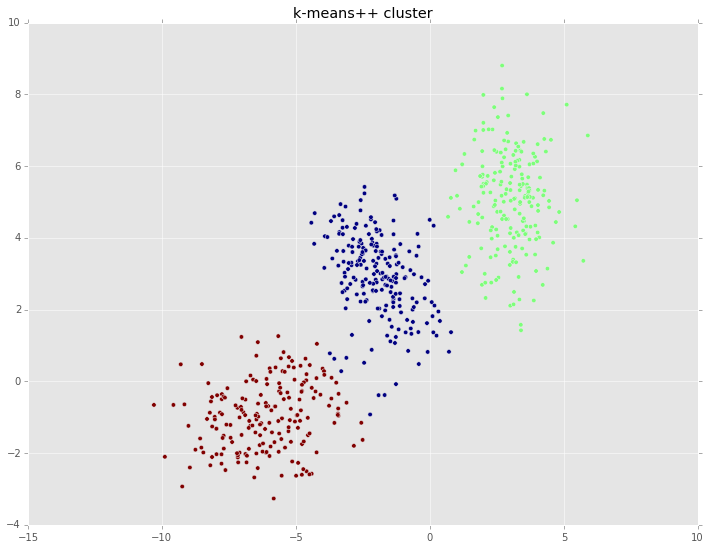

In [10]:
plt.figure(figsize=(12, 9));
plt.scatter(df.X,df.Y,c=km1.labels_);
plt.title("k-means++ cluster");

In [55]:
# import timeit

# start = timeit.timeit()
# km1 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001)
# km1.fit(df);
# end = timeit.timeit()
# print end - start

-6.8187713623e-05


## K-means||

In [11]:
##k-means||

##cost function
# Version 1 - 2 list comprehension, no broadcasting
# def cost(c,data):
#     return np.sum([min([euclidean(d,s) for s in c])**2 for d in data])

# Version 2 - 1 list comprehension and one broadcasting
def cost(c,data):
    return np.sum([min(np.sum((c-d)**2,axis=1)) for d in data])


#Oversampling factor -  according to the result in the paper, l=2k always performs best
l = 2*k

#sampling probability function
# Version 1 - 2 list comprehension, no broadcasting
# def smpl_prb(c,data,l):
#     phi_temp = cost(c,data)
#     return np.array([(min([euclidean(d,s) for s in c])**2)*l/phi_temp for d in data])

# Version 2 - 1 list comprehension, 1 broadcasting
def smpl_prb(c,data,l):
    phi_temp = cost(c,data)
    return np.array([(min(np.sum((c-d)**2,axis=1)))*l/phi_temp for d in data])

In [70]:
#l is oversampling factor -  according to the result in the paper, l=2k always performs best

def KmeansParallel(n_clusters, data, l):
    if n_clusters <= 0 or not(isinstance(n_clusters,int)):
        sys.exit("n_cluster is not positive integer")
    
    if l <= 0: 
        sys.exit("l is not positive")
    
    if len(data) < n_clusters: 
        sys.exit("number of data is less than n_clusters")
    
    #Step 1 - uniformly sample one point
    c = np.array(data[np.random.choice(range(N),1),])
    #Step 2 - cost
    phi = cost(c,data)
    #Step 3~6 - get potential centers
    for i in range(np.ceil(np.log(phi)).astype(int)):
        c_add = data[smpl_prb(c,data,l)>np.random.uniform(size = N),]
        c = np.concatenate((c,c_add))
    #Step 7

    # Find the closet point in c for each point in data
    # Version 1 - 2 list comprehension, no broadcasting
    # min_c = [np.argmin([euclidean(d,s) for s in c]) for d in data];
    # Version 2 - 1 list comprehension, 1 broadcasting
    min_c = [np.argmin(np.sum((c-d)**2,axis=1)) for d in data];

    ##number of points which is closest to each s in c
    num_closest = [min_c.count(i) for i in range(len(c))] # range( +1) because + initial one of c
    ##weight
    weight = num_closest/np.sum(num_closest)
    #Step 8 - recluster by kmeans++ initialization
    c_final = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(n_clusters-1):
        new_prb = smpl_prb(c_final,data_final,l) * weight
        c_fin_add = data[np.random.choice(range(len(c)),size=1,p=new_prb/np.sum(new_prb)),]
        c_final = np.concatenate((c_final,c_fin_add))
    import sklearn.cluster
    km2 = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init=1, init=c_final, max_iter=500, tol=0.0001)
    km2.fit(data);
    #return a KMeans type result - including: cluster_centers_, labels_, inertia_
    return km2
    

In [43]:
km = KmeansParallel(n_clusters = k, data = data, l = 2*k);

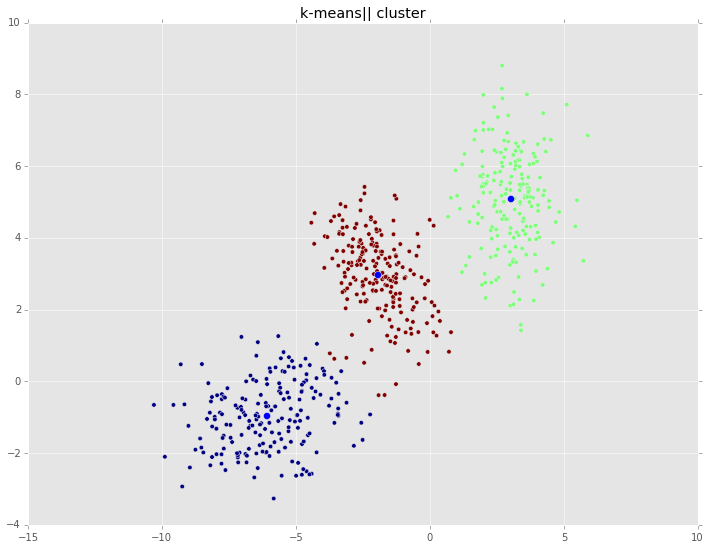

In [46]:
plt.figure(figsize=(12, 9));
plt.scatter(df.X,df.Y,c=km.labels_);
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],marker='o',s=50);
plt.title("k-means|| cluster");

## Initial code profile

k-means|| is a parallel version for initializing the centers of k-means clustering method. This algorithm is somehow intuitively similar to k-means++ while the main difference is the usage of an oversampling factor $l = \Omega(k)$, some linear function of $k$.
In the first step, we sample a point $C$ uniformly at random from data set as an initial center and compute the cost of this clustering center $\psi = \phi_X(C)$, where
\begin{equation}
\phi_X(C) = \sum_{x\in X} d^2(x,C) = \sum_{x\in X} min_{c_i \in C} ||x-c_i||^2
\end{equation}
Then we run a log$\varphi$ iterations for loop, where in each iteration, we samples each point $x$ in data set $X$ with probability $\frac{ld^2(x, C)}{\phi_X(C)}$, given current cluster center set $C$. 
We update $C$ with adding the sampled points and update the cluster cost quantity $\phi_X(C)$. Then we run next iteration until the for loop is completed. 
According to the sampling probability of each data points in each iteration in for loop, the expected number of points sampled in each iteration is $l$. Thus, finally the expected number of points we sampled is $l$log$\psi$, which is expected to be more than k. 
Therefore we have to reduce the number of centers and we assigns weights to the points in $C$ according to number of points in data set $X$ which the center are closer to them than any other centers.
\begin{equation}
\omega(c_i) =  \frac{\sum_{x\in X} 1_{(d^2(x,c_i) < d^2(x,C/\{c_i\}))}}{|X|}
\end{equation}

With the weight, we can reclusters these potential cluster centers to obtain k centers. In this step we combine the idea of k-means ++ with weight we obtain in last step. In other words, we sample k cluster centers by means of k-means ++ initialization method but we combine weight and distance when we compute the cost of the cluster centers. Firstly, we sample a center, $C_{final}$, from $C$ randomly with probability as weight $\vec{\omega}$. 
Then we run a $k-1$ iteration for loop, to obtain the rest of cluster centers, where in each iteration, we samples each point $c_i$ in set $C$ with probability $\frac{d^2(c_i, C)\omega(c_i)}{\phi_C(C_{final})}$, given current cluster center set $C$. 
We update $C_{final}$ with adding the sampled points and update the cluster cost quantity $\phi_C(C_{final})$. Then we run next iteration until the for loop is completed. 
\begin{equation}
\phi_C(C_{final}) = \sum_{c_i\in C} d^2(c_i,C_{final}) \omega(c_i)
\end{equation}
where $C_{final}$ is the final cluster center set.

Notice that the size of C is significantly smaller than the input size which means the reclustering can be done quickly. 
